In [2]:
%load_ext autoreload
%autoreload 2

from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import Adam
from keras.regularizers import l2


from spektral.datasets import delaunay
from spektral.layers import GraphAttention, GlobalAttentionPool
from spektral.utils import localpooling_filter

import numpy as np

import load_data as ld
import utilities
from evaluator import Evaluator
from embedder import Embedder
from embedder import Transformer
from embedder import Transformer_GNN
from embedder import Transformer_GNN_embedder

import tmp_generator as tmp
from visualizator import Visualizator


from sklearn.decomposition import TruncatedSVD

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from Graph_generator import Graph_Generator

n_graphs = 300


# 20 permutations
gg = Graph_Generator(n_graphs=n_graphs,
                     degree = 4)
g1, na1, ea1 = gg.generate(20,10,10,1)
g2, na2, ea2 = gg.generate(20,10,10,10)

graphs, labels = gg.generate_set(g1,g2,na1, ea1,na2, ea2,15,15,plot=False)



functions = [utilities.degree,utilities.clust_coefficient,utilities.local_degree_profile]
graphs = utilities.add_info_to_nodes(graphs,functions)


max_n_nodes, n_attributes = utilities.find_shapes(graphs)
n_classes = len(np.unique(labels))

print("done")

done


In [4]:
dim = [2,3,5]
my_GNN_small = tmp.gen_gnn_small(max_n_nodes,
                             n_attributes,
                             batch_size = 32,
                             validation_split = 0.2,
                             epochs = 100,
                             dim = dim,
                             plot = True)

m_1 = Transformer(my_GNN_small)
emb_1 = Embedder([m_1],"Spektral + small")


my_GNN = tmp.generate_GNN(max_n_nodes,
                      n_attributes,
                      n_classes,
                      batch_size = 32,
                      validation_split = 0.2,
                      epochs = 100,
                      verbose=0, 
                      plot=False)

m_2 = Transformer(my_GNN)
m_3 = Transformer(TruncatedSVD())
emb_2 = Embedder([m_2,m_3],"Spektral + PCA")

print("done") 

done


	 iteration n: 1
	 	 dim:  2
	 	 	  Spektral + small
reset state TRANSFORMER
reset state GNN embed


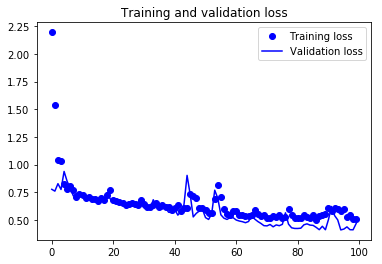

max loss 2.19626403990246
min loss 0.502706976163955
0
	 	 dim:  3
	 	 	  Spektral + small
reset state TRANSFORMER
reset state GNN embed


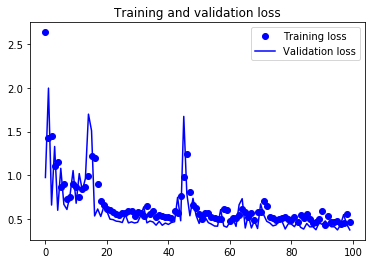

max loss 2.633977549416678
min loss 0.4316333731015523
0
	 	 dim:  5
	 	 	  Spektral + small
reset state TRANSFORMER
reset state GNN embed


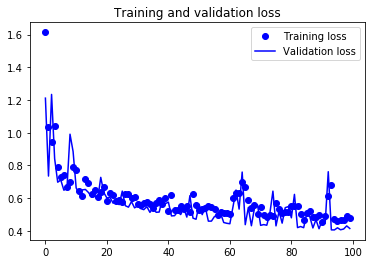

max loss 1.6145377613249279
min loss 0.452322876169568
0
	 iteration n: 2
	 	 dim:  2
	 	 	  Spektral + small
reset state TRANSFORMER
reset state GNN embed


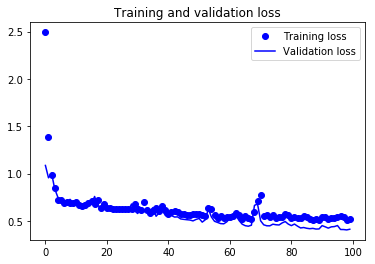

max loss 2.4923655646187917
min loss 0.5074390712238493
0
	 	 dim:  3
	 	 	  Spektral + small
reset state TRANSFORMER
reset state GNN embed


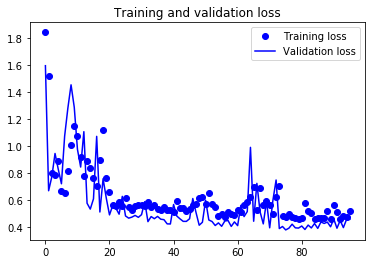

max loss 1.8402258214496432
min loss 0.4544852886881147
95
	 	 dim:  5
	 	 	  Spektral + small
reset state TRANSFORMER
reset state GNN embed


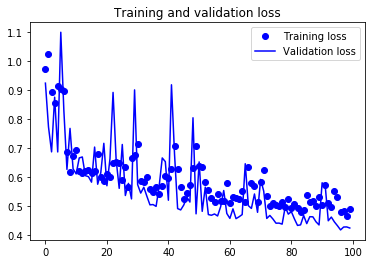

max loss 1.0258931602750505
min loss 0.4667714408465794
0
	 iteration n: 3
	 	 dim:  2
	 	 	  Spektral + small
reset state TRANSFORMER
reset state GNN embed


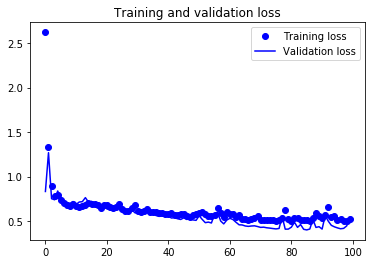

max loss 2.622289248875209
min loss 0.4990916663692111
0
	 	 dim:  3
	 	 	  Spektral + small
reset state TRANSFORMER
reset state GNN embed


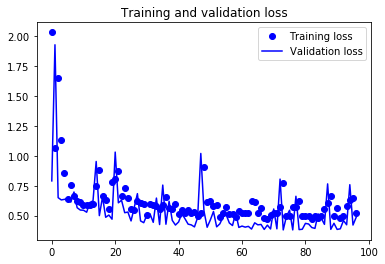

max loss 2.0341844104585194
min loss 0.4744352755092439
96
	 	 dim:  5
	 	 	  Spektral + small
reset state TRANSFORMER
reset state GNN embed


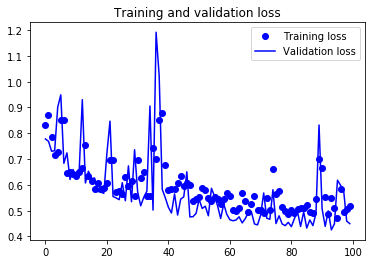

max loss 0.8772537353492919
min loss 0.470335990190506
0


In [5]:
emb = [emb_1]

times = 3
vis_500 = utilities.repeat_n_times(graphs, labels, emb, dim, times ,test_size=0.3,seed = 11)

In [6]:
vis_500.summary()

                     2    STD      3    STD      5    STD    mean
----------------  ----  -----  -----  -----  -----  -----  ------
Spektral + small  0.66  0.147  0.732  0.178  0.725  0.115   0.426


In [1]:
def gen_small(max_n_nodes, n_attributes,n_components):
    n_classes = 2

    learning_rate = 0.001
    l2_reg = 5e-4  
    
    ##### DEFINISCI MODELLO ORIGINALE
    X_in_1_1 = Input(shape=(max_n_nodes, n_attributes))
    filter_in_1_1 = Input((max_n_nodes, max_n_nodes))
    gc1_1_1 = GraphAttention(32, activation='relu', kernel_regularizer=l2(l2_reg))([X_in_1_1, filter_in_1_1])
    gc2_1_1 = GraphAttention(32, activation='relu', kernel_regularizer=l2(l2_reg))([gc1_1_1, filter_in_1_1])
    pool_1_1 = GlobalAttentionPool(128)(gc2_1_1)
    dense_x = Dense(n_components)(pool_1_1)
    output_1_1 = Dense(n_classes, activation='softmax')(dense_x)
    model_1_1 = Model(inputs=[X_in_1_1, filter_in_1_1], outputs=output_1_1)
    optimizer = Adam(lr=learning_rate)
    model_1_1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])


    ##### CREA IL SECONDO MODELLO
    X_in_1_2 = Input(shape=(max_n_nodes, n_attributes))
    filter_in_1_2 = Input((max_n_nodes, max_n_nodes))
    gc1_1_2 = GraphAttention(32, activation='relu', kernel_regularizer=l2(l2_reg))([X_in_1_2, filter_in_1_2])
    gc2_1_2 = GraphAttention(32, activation='relu', kernel_regularizer=l2(l2_reg))([gc1_1_2, filter_in_1_2])
    pool_1_2 = GlobalAttentionPool(128)(gc2_1_2)
    dense2_x = Dense(n_components)(pool_1_2)
    model_1_2 = Model(inputs=[X_in_1_2, filter_in_1_2], outputs=dense2_x)
    model_1_2.compile(optimizer=Adam(lr=learning_rate), loss='categorical_crossentropy', metrics=['acc'])
    
    
    return(model_1_1,model_1_2)

def  gen_gnn_small(max_n_nodes, n_attributes,batch_size,validation_split,epochs,dim,verbose=False,plot=False):


    original_models = []
    new_models = []
    
    for d in dim:
        original, new = gen_small(max_n_nodes, n_attributes, d)
        
        original_models.append(original)
        new_models.append(new)
    
    
    my_GNN_1 = Transformer_GNN_embedder(original_models = original_models,
                                      new_models = new_models,
                                      batch_size = batch_size,
                                      validation_split = validation_split,
                                      epochs = epochs,
                                      verbose = verbose,
                                      plot = plot)

    return(my_GNN_1)

In [2]:
class Transformer_GNN_embedder:

    def __init__(self, original_models,new_models,batch_size,validation_split,epochs,verbose=0,dim=[2,3,5],plot=False):
        
        self.original_models = original_models
        self.new_models = new_models
        
        self.batch_size = batch_size
        self.validation_split = validation_split
        self.epochs = epochs
        self.verbose = verbose
        
        
        self.dim = dim 
        self.selected_model = 0
        self.n_components = 0
        
        self.original_weights = []
        
        # store the original weigths (the one assigned when the net is compiled)
        
        for original in original_models:
            self.original_weights.append(original.get_weights())
        
        
        ###
        self.plot = plot

        
    def reset_state(self):
        print ("reset state GNN embed")
        for i in range(len(self.original_models)):
            self.original_models[i].set_weights(self.original_weights[i])

    
    def fit(self,graphs,y):
        
        # select the right model
        self.selected_model = self.dim.index(self.n_components)
        
        
        # Preprocessing
        adj, x, _ = utilities.from_nx_to_adj(graphs)
        fltr = localpooling_filter(adj)
        y_one_hot = utilities.from_np_to_one_hot(y)
        
        # callback
        es_callback = EarlyStopping(monitor='val_loss', patience=20)
        
        
        ### the dataset is splitted, and the input of the model
        ### acceps max_n_nodes as impout, so if needed add a padding
        fltr, x = self.add_padding(fltr,x)

        
        history = self.original_models[self.selected_model].fit([x, fltr],y_one_hot,
                                                                batch_size=self.batch_size,
                                                                validation_split=self.validation_split,
                                                                epochs=self.epochs,
                                                                callbacks=[es_callback],
                                                                verbose=self.verbose)
        if (self.plot == True):
            tmp_print(history)

        print(es_callback.stopped_epoch)
        
        
        current_weights = self.original_models[self.selected_model].get_weights()
        self.new_models[self.selected_model].set_weights(current_weights)

        return(self)
    
    
    
    def transform(self,graphs):
        
        # preprocessing
        adj, x, _ = utilities.from_nx_to_adj(graphs)
        fltr = localpooling_filter(adj)
        fltr, x = self.add_padding(fltr,x)
            
        y_pred = self.new_models[self.selected_model].predict([x,fltr])
        
        return(y_pred)


    def add_padding(self,fltr,x):
        
        input_model = self.original_models[self.selected_model].get_input_shape_at(0)
        #### pad fltr
        new_fltr = []
        if (not fltr.shape[1] == input_model[1][1]):

            pad_size = input_model[1][1] - fltr.shape[1]
            
            for i in fltr:
                new_fltr.append(np.pad(i, (0,pad_size), 'constant', constant_values=(0)))
        else:
            return(fltr,x)   
                
        # pad x
        new_x = []
        if (not x.shape[1] == input_model[0][1]):
            
            for x_matrix in x:
                pad_size = input_model[0][1] - x.shape[1]
                z = np.zeros(len(x_matrix[0]))

                new_x_matrix = []
                for row in x_matrix:
                    new_x_matrix.append(row)
                for i in range(0,pad_size):
                    new_x_matrix.append(z)

                new_x_matrix = np.asarray(new_x_matrix)
                new_x.append(new_x_matrix)

            new_x = np.asarray(new_x)
        else:
            new_x = x


        new_fltr = np.asarray(new_fltr)

        return(new_fltr, new_x)



In [3]:
############### OLD

class Transformer_GNN_small:

    def __init__(self, original_model,new_model,batch_size,validation_split,epochs,verbose=0,plot=False):
        self.original_model = original_model
        self.new_model = new_model
        self.batch_size = batch_size
        self.validation_split = validation_split
        self.epochs = epochs
        self.verbose = verbose
        
        self.initial_weights = []
        self.original_weights = []
        
        for model in original_model:
            self.initial_weights.append(model.get_weights())
            self.original_weights.append(model.get_weights())
        
        
        self.n_components = 2
        self.n_components_old = 2
        self.selected_model = 0
        
        
        ###
        self.plot = plot


        
    def reset_state(self):
        print("in RESET STATE")
        c = 0         
        for model in self.original_model:
            model.set_weights(self.initial_weights[c])
            c = c + 1
        c = 0
        for model in self.new_model:
            model.set_weights(self.initial_weights[c])
            c = c + 1
        
    def fit(self,graphs,y):
        # Preprocessing
        
        ######## tmp reset the state
        
        self.original_model[self.selected_model].set_weights(self.initial_weights[self.selected_model])
        
        
        adj, x, _ = utilities.from_nx_to_adj(graphs)
        fltr = localpooling_filter(adj)
        y_one_hot = utilities.from_np_to_one_hot(y)
        es_callback = EarlyStopping(monitor='val_loss', patience=20)
        
        ### the dataset is splitted, and the input of the model
        ### acceps max_n_nodes as impout, so if needed add a padding
        fltr, x = self.add_padding(fltr,x)

        
        history = self.original_model[self.selected_model].fit([x, fltr],y_one_hot,
                                                    batch_size=self.batch_size,
                                                    validation_split=self.validation_split,
                                                    epochs=self.epochs,
                                                    callbacks=[es_callback],
                                                    verbose=self.verbose)
        if (self.plot == True):
            tmp_print(history)

        print(es_callback.stopped_epoch)
        
        ### get the weights
        self.original_weights[self.selected_model] = self.original_model[self.selected_model].get_weights()
            
        ### set the weights to the new models
        self.new_model[self.selected_model].set_weights(self.original_weights[self.selected_model])


        return(self)
    
    
    def transform(self,graphs):
        adj, x, _ = utilities.from_nx_to_adj(graphs)
        fltr = localpooling_filter(adj)
        fltr, x = self.add_padding(fltr,x)
        
        if (self.n_components_old == self.n_components):
            self.selected_model = 0
        else:
            self.selected_model = self.selected_model + 1
            self.n_components_old = self.n_components
            
        y_pred = self.new_model[self.selected_model].predict([x,fltr])
        return(y_pred)


    def add_padding(self,fltr,x):
        
        input_model = self.original_model[self.selected_model].get_input_shape_at(0)
        #### pad fltr
        new_fltr = []
        if (not fltr.shape[1] == input_model[1][1]):

            pad_size = input_model[1][1] - fltr.shape[1]
            
            for i in fltr:
                new_fltr.append(np.pad(i, (0,pad_size), 'constant', constant_values=(0)))
        else:
            return(fltr,x)   
                
        # pad x
        new_x = []
        if (not x.shape[1] == input_model[0][1]):
            
            for x_matrix in x:
                pad_size = input_model[0][1] - x.shape[1]
                z = np.zeros(len(x_matrix[0]))

                new_x_matrix = []
                for row in x_matrix:
                    new_x_matrix.append(row)
                for i in range(0,pad_size):
                    new_x_matrix.append(z)

                new_x_matrix = np.asarray(new_x_matrix)
                new_x.append(new_x_matrix)

            new_x = np.asarray(new_x)
        else:
            new_x = x


        new_fltr = np.asarray(new_fltr)

        return(new_fltr, new_x)


In [4]:
import matplotlib.pyplot as plt
def tmp_print(model_history):  

    loss = model_history.history['loss']

    val_loss = model_history.history['val_loss']

    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()
    
    print("max loss", np.max(loss))
    print("min loss", np.min(loss))

In [10]:
class Transformer_GNN:

    def __init__(self, original_model,new_model,batch_size,validation_split,epochs,verbose=0,plot=False):
        self.original_model = original_model
        self.new_model = new_model
        self.batch_size = batch_size
        self.validation_split = validation_split
        self.epochs = epochs
        self.verbose = verbose
        
        self.initial_weights = original_model.get_weights()

        ####
        self.plot = plot


        
    def reset_state(self):
        print("reset_state GNN")
        self.original_model.set_weights(self.initial_weights)
        self.new_model.set_weights(self.initial_weights)
        
        
    def fit(self,graphs,y):
        # Preprocessing
        adj, x, _ = utilities.from_nx_to_adj(graphs)
        fltr = localpooling_filter(adj)
        y_one_hot = utilities.from_np_to_one_hot(y)
        es_callback = EarlyStopping(monitor='val_loss', patience=20)
        
        ### the dataset is splitted, and the input of the model
        ### acceps max_n_nodes as impout, so if needed add a padding
        fltr, x = self.add_padding(fltr,x)

        history = self.original_model.fit([x, fltr],y_one_hot,
                                batch_size=self.batch_size,
                                validation_split=self.validation_split,
                                epochs=self.epochs,
                                callbacks=[es_callback],
                                verbose=self.verbose)
        
        if (self.plot == True):
            tmp_print(history)
        
        
        print(es_callback.stopped_epoch)
        
        ### get the weights
        self.original_weights = self.original_model.get_weights()
        ### set the weights to the new models
        self.new_model.set_weights(self.original_weights)


        return(self)
    
    
    def transform(self,graphs):
        adj, x, _ = utilities.from_nx_to_adj(graphs)
        fltr = localpooling_filter(adj)
        fltr, x = self.add_padding(fltr,x)
        y_pred = self.new_model.predict([x,fltr])
        return(y_pred)


    def add_padding(self,fltr,x):
        
        input_model = self.original_model.get_input_shape_at(0)
        #### pad fltr
        new_fltr = []
        if (not fltr.shape[1] == input_model[1][1]):

            pad_size = input_model[1][1] - fltr.shape[1]
            
            for i in fltr:
                new_fltr.append(np.pad(i, (0,pad_size), 'constant', constant_values=(0)))
        else:
            return(fltr,x)   
                
        # pad x
        new_x = []
        if (not x.shape[1] == input_model[0][1]):
            
            for x_matrix in x:
                pad_size = input_model[0][1] - x.shape[1]
                z = np.zeros(len(x_matrix[0]))

                new_x_matrix = []
                for row in x_matrix:
                    new_x_matrix.append(row)
                for i in range(0,pad_size):
                    new_x_matrix.append(z)

                new_x_matrix = np.asarray(new_x_matrix)
                new_x.append(new_x_matrix)

            new_x = np.asarray(new_x)
        else:
            new_x = x


        new_fltr = np.asarray(new_fltr)

        return(new_fltr, new_x)


In [11]:
def generate_GNN(max_n_nodes,n_attributes,n_classes,batch_size = 32,
                 validation_split = 0.1,epochs = 100,verbose=0, plot=False):
    

    learning_rate = 0.001
    l2_reg = 5e-4  

    ##### DEFINISCI MODELLO ORIGINALE
    X_in_1_1 = Input(shape=(max_n_nodes, n_attributes))
    filter_in_1_1 = Input((max_n_nodes, max_n_nodes))
    gc1_1_1 = GraphAttention(32, activation='relu', kernel_regularizer=l2(l2_reg))([X_in_1_1, filter_in_1_1])
    gc2_1_1 = GraphAttention(32, activation='relu', kernel_regularizer=l2(l2_reg))([gc1_1_1, filter_in_1_1])
    pool_1_1 = GlobalAttentionPool(128)(gc2_1_1)
    output_1_1 = Dense(n_classes, activation='softmax')(pool_1_1)
    model_1_1 = Model(inputs=[X_in_1_1, filter_in_1_1], outputs=output_1_1)
    optimizer = Adam(lr=learning_rate)
    model_1_1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])


    ##### CREA IL SECONDO MODELLO
    X_in_1_2 = Input(shape=(max_n_nodes, n_attributes))
    filter_in_1_2 = Input((max_n_nodes, max_n_nodes))
    gc1_1_2 = GraphAttention(32, activation='relu', kernel_regularizer=l2(l2_reg))([X_in_1_2, filter_in_1_2])
    gc2_1_2 = GraphAttention(32, activation='relu', kernel_regularizer=l2(l2_reg))([gc1_1_2, filter_in_1_2])
    pool_1_2 = GlobalAttentionPool(128)(gc2_1_2)
    model_1_2 = Model(inputs=[X_in_1_2, filter_in_1_2], outputs=pool_1_2)
    model_1_2.compile(optimizer=Adam(lr=learning_rate), loss='categorical_crossentropy', metrics=['acc'])


    my_GNN_1 = Transformer_GNN(original_model = model_1_1,
                                      new_model = model_1_2,
                                      batch_size = batch_size,
                                      validation_split = validation_split,
                                      epochs = epochs,
                                      verbose=verbose,
                                      plot=plot)
    
    
    return(my_GNN_1)